In [24]:
pip install ollama

Note: you may need to restart the kernel to use updated packages.


In [25]:
import ollama
import numpy as np
import os
import pandas as pd
import json

In [26]:
ollama.pull('llama3.2')

ProgressResponse(status='success', completed=None, total=None, digest=None)

In [27]:
model_vars = {'temperature' : 0.7,
               'num_predict' : 1,
               #'repeat_last_n' : 1,
               'repeat_penalty' : 1,
               'top_k' : 10,
               'top_p' : 0.9}


In [28]:

def generate_answer(prompt_content : str, model_settings = model_vars, used_model = 'llama3.2') -> str:
    response = ollama.chat(model = used_model, messages=[
    {
    'role': 'user',
    'content': prompt_content,
    },],
    options = model_settings)
    return response['message']['content']

In [29]:
path = os.getcwd()
path = os.path.join(path, "COVID_tweets_dataset", "Corona_balanced.csv")


data = pd.read_csv(path)

#creating new column mapping Sentiment into integers
sentiment_mapping = {
    'Negative': 2,
    'Neutral': 3,
    'Positive': 4,
    'Extremely Negative': 1,
    'Extremely Positive': 5
}
data['Sentiment_float'] = data['Sentiment'].map(sentiment_mapping).astype(float)
data.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,UserName,OriginalTweet,Sentiment,Sentiment_float
0,0,0,0,1,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,1.0
1,1,1,1,9,HI TWITTER! I am a pharmacist. I sell hand san...,Extremely Negative,1.0
2,2,2,2,12,Beware of counterfeits trying to sell fake mas...,Extremely Negative,1.0
3,3,3,3,13,Panic food buying in Germany due to #coronavir...,Extremely Negative,1.0
4,4,4,4,16,#AirSewa \r\r\n\r\r\n@flyspicejet is not provi...,Extremely Negative,1.0


In [30]:
X = data['OriginalTweet']
y = data['Sentiment_float']

In [31]:
from collections import Counter
from sklearn.metrics import accuracy_score, mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


json_path = "prompts_examples.json"
with open(json_path, "r") as file:
    prompt_data = json.load(file)

#Storing answers
all_answers = {}
metrics = {}
invalid_samples_total = 0

# Iterate over all prompts
for prompt_num in range(1, 6):
    gen_prompt = prompt_data["generated_prompts"]["prompt_" + str(prompt_num)]
    answers = []
    invalid_samples = 0
    
    for tweet in X:
        ans = generate_answer(
            prompt_content=gen_prompt.replace("[INSERT TWEET HERE]", tweet)
        )
        
        
        # Eventual mapping
        sentiment_mapping = {
            'Negative': 2,
            'Neutral': 3,
            'Positive': 4,
            'Extremely Negative': 1,
            'Extremely Positive': 5
        }
        
        if ans in sentiment_mapping.keys():
            ans = sentiment_mapping[ans]
        else:
            try:
                ans = int(ans)
                if ans < 1 or ans > 5:
                    raise KeyError
            except:
                invalid_samples += 1
                ans = np.random.randint(low=1, high=5)
        
        answers.append(ans)
    
    # Store results for given prompt
    all_answers[prompt_num] = {
        "answers": answers,
        "invalid_samples": invalid_samples
    }
    invalid_samples_total += invalid_samples

    # Calculate metrics
    accuracy = accuracy_score(y, answers)
    mae = mean_absolute_error(y, answers)
    conf_matrix = confusion_matrix(y, answers, labels = [1,2,3,4,5])

    metrics[prompt_num] = {
    "accuracy": accuracy,
    "mae": mae,
    "confusion_matrix": conf_matrix
}



In [32]:
# Displaying summarized results
for prompt_num, results in all_answers.items():
    print(f"Prompt {prompt_num} - Invalid Samples: {results['invalid_samples']}")
    print(f"Prompt {prompt_num} - Most Common Answers: {Counter(results['answers'])}")
    
print(f"Total Invalid Samples: {invalid_samples_total}")
print(f"Real labels: {Counter(y)}")

Prompt 1 - Invalid Samples: 1
Prompt 1 - Most Common Answers: Counter({3: 817, 4: 810, 2: 319, 5: 41, 1: 13})
Prompt 2 - Invalid Samples: 5
Prompt 2 - Most Common Answers: Counter({4: 994, 3: 578, 2: 271, 5: 141, 1: 16})
Prompt 3 - Invalid Samples: 31
Prompt 3 - Most Common Answers: Counter({4: 1229, 3: 549, 2: 153, 5: 58, 1: 11})
Prompt 4 - Invalid Samples: 2
Prompt 4 - Most Common Answers: Counter({4: 1291, 3: 546, 2: 94, 5: 65, 1: 4})
Prompt 5 - Invalid Samples: 9
Prompt 5 - Most Common Answers: Counter({4: 1129, 3: 606, 2: 190, 5: 69, 1: 6})
Total Invalid Samples: 48
Real labels: Counter({1.0: 400, 4.0: 400, 5.0: 400, 2.0: 400, 3.0: 400})



Metrics for Prompt 1:
Accuracy: 0.205
Mean Absolute Error (MAE): 1.3495
Confusion Matrix:


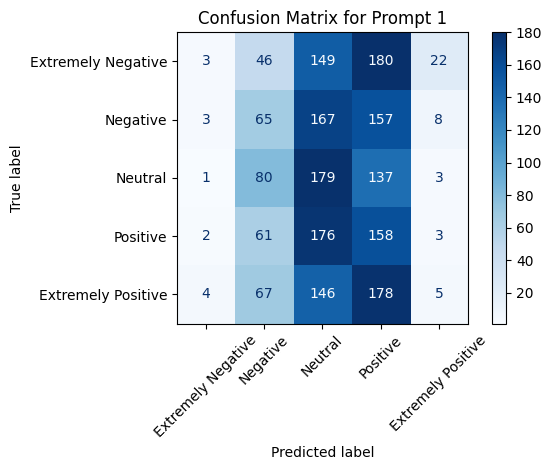


Metrics for Prompt 2:
Accuracy: 0.1875
Mean Absolute Error (MAE): 1.4445
Confusion Matrix:


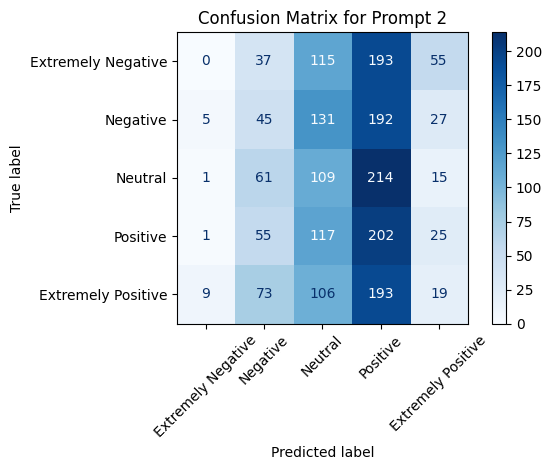


Metrics for Prompt 3:
Accuracy: 0.193
Mean Absolute Error (MAE): 1.386
Confusion Matrix:


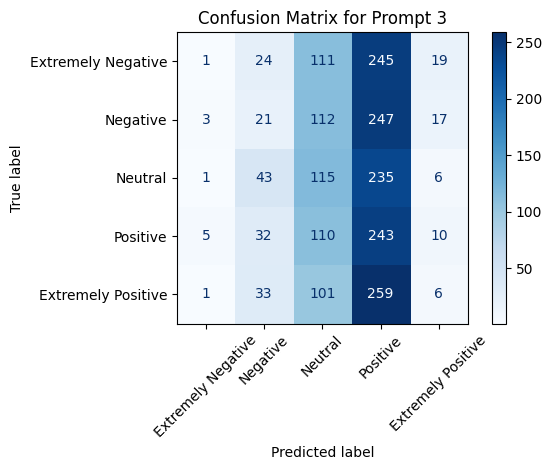


Metrics for Prompt 4:
Accuracy: 0.186
Mean Absolute Error (MAE): 1.4075
Confusion Matrix:


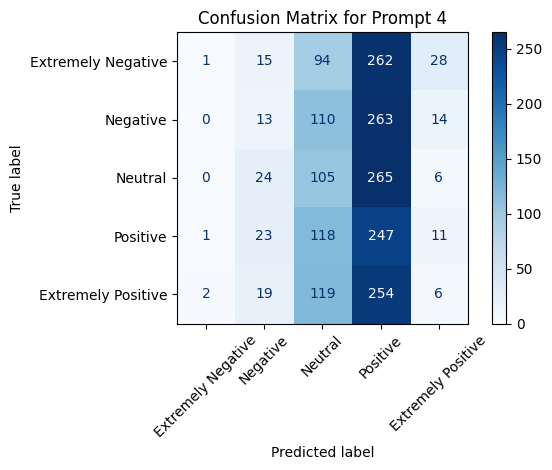


Metrics for Prompt 5:
Accuracy: 0.194
Mean Absolute Error (MAE): 1.4045
Confusion Matrix:


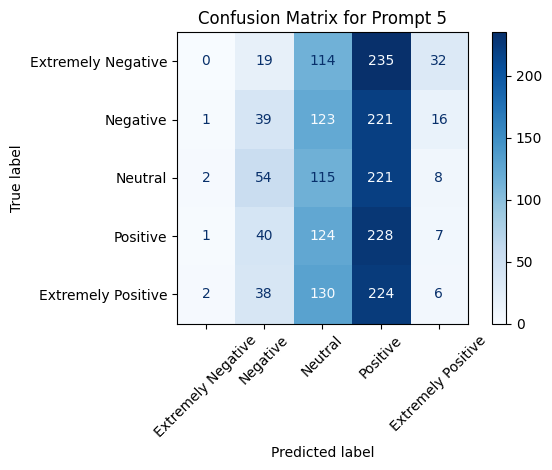

In [33]:
# Display metrics
for prompt_num, metric_values in metrics.items():
    print(f"\nMetrics for Prompt {prompt_num}:")
    print(f"Accuracy: {metric_values['accuracy']}")
    print(f"Mean Absolute Error (MAE): {metric_values['mae']}")
    print("Confusion Matrix:")




    disp = ConfusionMatrixDisplay(confusion_matrix=metric_values['confusion_matrix'],
                                   display_labels=['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'])
    disp.plot(cmap=plt.cm.Blues, xticks_rotation = 45)
    plt.title(f"Confusion Matrix for Prompt {prompt_num}")
    os.makedirs("result_graphs/prompts_results", exist_ok=True)
    plt.tight_layout()
    plt.savefig(f"result_graphs/prompts_results/conf_matrix_gen_prompt_{prompt_num}.png")
    plt.show()


In [34]:
#saving results into txt log file
os.makedirs("logs_results", exist_ok = True)

#checking for latest version of log
existing_logs = [f for f in os.listdir("logs_results") if f.startswith("generated_prompts_log_v")]
if existing_logs:
    latest_version = max([int(f.split("_v")[1].split(".")[0]) for f in existing_logs])
    new_version = latest_version + 1
else:
    new_version = 1
    
prompt_log_path = f"logs_results/generated_prompts_log_v{new_version}.txt"

with open(prompt_log_path, "w") as log_file:
    log_file.write(f"MODEL SETTINGS: \n{model_vars}\n\n\n")

    for prompt_num in range(1, 6):

        log_file.write("-"*100)
        prompt_text = prompt_data["generated_prompts"]["prompt_" + str(prompt_num)]
        log_file.write(f"\nPROMPT NUMBER {prompt_num}\nPrompt text: \n{prompt_text}\n\n")
        #Invalid samples 
        results = all_answers[prompt_num]
        log_file.write(f"Prompt {prompt_num} - Invalid Samples: {results['invalid_samples']}\n")
        log_file.write(f"Prompt {prompt_num} - Most Common Answers: {Counter(results['answers'])}\n")

        #Metrics
        metric_values = metrics[prompt_num]
        log_file.write(f"\nMetrics for Prompt {prompt_num}:")
        log_file.write(f"\nAccuracy: {metric_values['accuracy']}")
        log_file.write(f"\nMean Absolute Error (MAE): {metric_values['mae']}\n\n\n")